## Merging all catchments output discharge files into one for a watershed

In [18]:
# Importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure

import pandas as pd
import os
import re

from tqdm.notebook import tqdm

In [13]:
# watershed ID and directory
wb_id = "wb-694856"

# storm name
storm_name = "Barry"

In [4]:
# change the directory 
os.chdir(f"Tropical Storm Barry/{wb_id}/outputs")

In [5]:
# check the current directory
os.getcwd()

'/home/jovyan/data/ngen-cfe-hydrological-model/notebooks/ngen/Tropical Storm Barry/wb-694856/outputs'

In [9]:
def get_catchment_id(filename):
    """
    Extracts catchment ID from the given filename.

    Args:
    filename : str : Name of the file.

    Returns:
    str : Catchment ID prefixed by 'catch-', suffixed by '-discharge', or None if no match.
    """

    # Regular expression search to find the catchment ID in the filename
    match = re.search(r'nex-(\d+)_output.csv', filename)
    
    # If a match is found, prefix 'catch-', suffix '-discharge' and return. If no match, return None.
    return 'catch-' + match.group(1) + '-discharge' if match else None

In [10]:
# List all CSV files in the directory that start with 'nex'
csv_files = [f for f in os.listdir() if f.endswith('.csv') and f.startswith('nex')]

In [12]:
# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

# Iterate over each CSV file in the list
for file in tqdm(csv_files):
    # Read the CSV file into a DataFrame, specifying column names
    df = pd.read_csv(file, header=None, names=['index', 'time', 'river_discharge'])
    
    # Drop the 'index' column from the DataFrame
    df = df.drop(columns=['index'])

    # Extract catchment ID from the file name
    catchment_id = get_catchment_id(file)

    # Rename the 'output river discharge' column to the catchment ID with '-discharge' suffix
    df = df.rename(columns={'river_discharge': catchment_id})

    # If all_data is still empty, copy df. Otherwise, merge df into all_data on 'date and time' column.
    if all_data.empty:
        all_data = df
    else:
        all_data = pd.merge(all_data, df, on='time', how='outer')

# Write the merged DataFrame to a new CSV file
all_data.to_csv(f'../{wb_id}_merged_output.csv', index=False)


  0%|          | 0/1917 [00:00<?, ?it/s]

## Plot the data

In [21]:
data = all_data.copy()

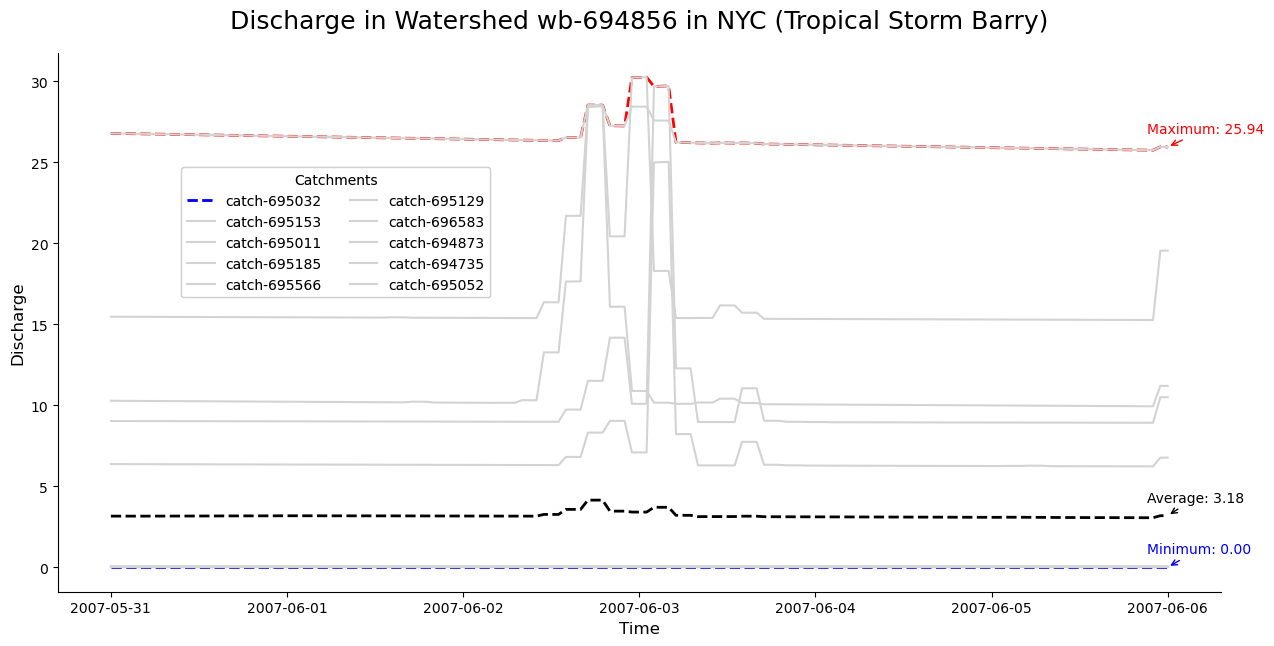

In [48]:
# Converting the 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])

# Identifying the discharge columns
discharge_cols = [col for col in data.columns if 'discharge' in col.lower()]

# Calculating the average, minimum, and maximum of the discharge columns
data['average'] = data[discharge_cols].mean(axis=1)
data['minimum'] = data[discharge_cols].min(axis=1)
data['maximum'] = data[discharge_cols].max(axis=1)

# Identifying the top 5 columns with the highest and lowest maximum discharge
max_values = data[discharge_cols].max()
top_5_highest = max_values.nlargest(5).index.tolist()
top_5_lowest = max_values.nsmallest(5).index.tolist()
subset_cols = top_5_highest + top_5_lowest

# Creating a new figure
fig, ax = plt.subplots(figsize=(15, 7))

# Defining the colors for the special lines
special_lines = {'average': 'black', 'minimum': 'blue', 'maximum': 'red'}

# Plotting the average, minimum, and maximum discharges
for line, color in special_lines.items():
    ax.plot(data['time'], data[line], label=line, linewidth=2, linestyle='--', color=color)

# Plotting the discharge data for the subset of columns
for col in subset_cols:
    ax.plot(data['time'], data[col], label=col.replace('-discharge', ''), color='lightgray')

# Set the title and labels
ax.set_title(f'Discharge in Watershed {wb_id} in NYC (Tropical Storm Barry)', fontsize=18, y=1.03)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Discharge', fontsize=12)

# Removing the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Customizing the legend
handles, labels = ax.get_legend_handles_labels()
h_special = [handles.pop(labels.index(l)) for l in special_lines]
l_special = [labels.pop(labels.index(l)) for l in special_lines]
h_discharge = handles
l_discharge = labels

# Creating two legends: one for special lines, another for discharge columns
legend_discharge = ax.legend(h_discharge, l_discharge, loc='upper left', bbox_to_anchor=(0.10, 0.8), title='Catchments', ncol=2)
# legend_special = ax.legend(h_special, l_special, loc='upper left', bbox_to_anchor=(0.70, 0.8), title='Statistics')
ax.add_artist(legend_discharge)

# Adding average, minimum, and maximum values to the plot as annotation
for line, color in special_lines.items():
    value = data[line].iat[-1]
    pos = data['time'].iat[-1]
    ax.annotate(f'{line.capitalize()}: {value:.2f}', xy=(pos, value), xycoords='data', color=color, xytext=(-15, 10), 
                textcoords='offset points', arrowprops=dict(arrowstyle="->", color=color))

# Adjusting the layout
# fig.subplots_adjust(right=0.8)

# Save the figure 
fig.savefig(f"../{wb_id}_discharge_{storm_name}.png", dpi=400, bbox_inches='tight')

plt.show()